# Converting Images into Structured Arrays and Scalars

In [ ]:
!pip install wget
import wget
wget.download('https://www.dropbox.com/s/l98leemr7r5stnm/Hemanvi.jpeg')

In [ ]:
!pip install opencv-python

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./Hemanvi.jpeg')

In [ ]:
img.shape

In [ ]:
img = img[50:250, 40:240]
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap = 'gray')

In [ ]:
img_gray.shape

In [ ]:
img_gray_small = cv2.resize(img_gray, (50, 50))
plt.imshow(img_gray_small, cmap = 'gray')

In [ ]:
print(img_gray_small)

In [ ]:
print(img_gray)

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./Hemanvi.jpeg')

In [ ]:
img = img[50:250, 40:240, :]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
plt.imshow(img)
print(img.shape)

In [ ]:
crop = img[-3:, -3:, :]
plt.imshow(crop)
print(crop)

In [ ]:
plt.imshow(img[:,:,2])

# FashionMNIST Dataset

In [ ]:
from torchvision import datasets
import torch

data_folder = './data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder,
                               download = True,
                               train = True)

In [ ]:
fmnist

In [ ]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [ ]:
tr_images.shape

In [ ]:
tr_targets.shape

In [ ]:
tr_targets.unique()

In [ ]:
fmnist.classes

In [ ]:
dir(fmnist)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10,10))
for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(tr_targets == label_class)[0]
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

# Training a Neural Network

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
data_folder = './data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder,
                               download = True,
                               train = True)

In [ ]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1, 28*28)
        self.x = x
        self.y = y
    def __getitem__(self, ix):
        x = self.x[ix]
        y = self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)        

In [ ]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size = 32, shuffle = True)
    return trn_dl

In [ ]:
from torch.optim import SGD

def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    
    loss_func = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr = 1e-2)
    
    return model, loss_func, optimizer

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

In [ ]:
@torch.no_grad()

def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
trn_dl = get_data()

In [ ]:
model, loss_fn, optimizer = get_model()

In [ ]:
losses, accuracies = [], []

In [ ]:
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

In [ ]:
epochs = np.arange(5) + 1
plt.plot(epochs, losses, label = 'Training Loss')
plt.title('Loss Value over incresing Epochs')
plt.legend()

In [ ]:
epochs = np.arange(5) + 1
plt.plot(epochs, accuracies, label = 'Training Accuracy')
plt.legend()
plt.title('Accuracy Value over incresing Epochs')

# Scaling Dataset to improve Model Accuracy

In [ ]:
from torchvision import datasets
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
data_folder = './data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder,
                               download = True,
                               train = True)

In [ ]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255.0
        x = x.view(-1, 28*28)
        self.x = x
        self.y = y
    def __getitem__(self, ix):
        x = self.x[ix]
        y = self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [ ]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size = 32, shuffle = True)
    return trn_dl

In [ ]:
from torch.optim import SGD

def get_model():
    model = nn.Sequential(nn.Linear(28*28, 1000),
                          nn.ReLU(),
                          nn.Linear(1000, 10)).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr = 1e-2)
    return model, loss_fn, optimizer

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

In [ ]:
@torch.no_grad()

def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()
losses, accuracies = [], []

for epoch in range(1, 6, 1):
    print(f"Epoch - {epoch}")
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(5) + 1
plt.plot(epochs, losses, label = 'Traing Loss')
plt.legend()

In [ ]:
epochs = np.arange(5) + 1
plt.plot(epochs, accuracies, label = 'Traing Accuracy')
plt.legend()

# Understanding the impact of varying the batch size = 32

In [ ]:
from torchvision import datasets
import torch

data_folder = './data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder,
                               download = True,
                               train = True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [ ]:
val_fmnist = datasets.FashionMNIST(data_folder,
                                   download = True,
                                   train = False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import SGD, Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class FashionMNIST(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255.0
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [ ]:
def get_model():
    model = nn.Sequential(nn.Linear(28*28, 1000),
                          nn.ReLU(),
                          nn.Linear(1000, 10).to(device)
                         )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = 1e-2)
    return model, loss_fn, optimizer

In [ ]:
def train_batch(x, y, model, loss_fn, optimizer):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
def get_data():
    train = FashionMNIST(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size = 32, shuffle = True)
    val = FashionMNIST(val_images, val_targets)
    val_dl = DataLoader(val, batch_size = len(val_images), shuffle = False)
    return trn_dl, val_dl

In [ ]:
@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
for epoch in range(5):
    print(f'epoch# {epoch}')
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(5) + 1
#plt.subplot(2,1,1)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_losses, 'r', label = 'Training Loss')
plt.plot(epochs, val_losses, 'b', label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Losses when batch size=32')
plt.grid('off')

#plt.subplot(2,1,2)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_accuracies, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'b', label = 'Validation Acurracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('Train/Val Accuracies when batch size=32')
plt.grid('off')
plt.show()

# Understanding the impact of varying the batch size = 10000

In [ ]:
def getdata():
    train = FashionMNIST(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size = 10000, shuffle = True)
    val = FashionMNIST(val_images, val_targets)
    val_dl = DataLoader(val, batch_size = len(val_images), shuffle = False)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = getdata()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
for epoch in range(20):
    print(f'epoch# {epoch+1}')
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(20) + 1
#plt.subplot(2,1,1)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_losses, 'r', label = 'Training Loss')
plt.plot(epochs, val_losses, 'b', label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Losses when batch size=10000')
plt.grid('off')

#plt.subplot(2,1,2)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_accuracies, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'b', label = 'Validation Acurracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('Train/Val Accuracies when batch size=10000')
plt.grid('off')
plt.show()

# Understanding the impact of varying the loss optimizer (SGD)

In [ ]:
from torch.optim import SGD, Adam

def get_model():
    model = nn.Sequential(nn.Linear(28*28, 1000),
                          nn.ReLU(),
                          nn.Linear(1000, 10).to(device)
                         )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr = 1e-2)
    return model, loss_fn, optimizer

In [ ]:
def getdata():
    train = FashionMNIST(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size = 32, shuffle = True)
    val = FashionMNIST(val_images, val_targets)
    val_dl = DataLoader(val, batch_size = len(val_images), shuffle = False)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = getdata()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
for epoch in range(10):
    print(f'epoch# {epoch+1}')
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(10) + 1
#plt.subplot(2,1,1)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_losses, 'bo', label = 'Training Loss')
plt.plot(epochs, val_losses, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Losses when batch size=32 & Opt is SGD')
plt.grid('off')

#plt.subplot(2,1,2)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_accuracies, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label = 'Validation Acurracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('Train/Val Accuracies when batch size=32 & Opt is SGD')
plt.grid('off')
plt.show()

# Understanding the impact of varying the loss optimizer (Adam)

In [ ]:
from torch.optim import SGD, Adam

def get_model():
    model = nn.Sequential(nn.Linear(28*28, 1000),
                          nn.ReLU(),
                          nn.Linear(1000, 10).to(device)
                         )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = 1e-2)
    return model, loss_fn, optimizer

In [ ]:
def getdata():
    train = FashionMNIST(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size = 32, shuffle = True)
    val = FashionMNIST(val_images, val_targets)
    val_dl = DataLoader(val, batch_size = len(val_images), shuffle = False)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = getdata()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(10):
    print(f'epoch# {epoch+1}')
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(10) + 1
#plt.subplot(2,1,1)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_losses, 'bo', label = 'Training Loss')
plt.plot(epochs, val_losses, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Losses when batch size=32 & Opt is Adam')
plt.grid('off')

#plt.subplot(2,1,2)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_accuracies, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label = 'Validation Acurracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train/Val Accuracies when batch size=32 & Opt is Adam')
plt.grid('off')
plt.show()

# Impact of learning rate on scaled dataset (lr=0.1, Opt=Adam, Batch_Size=32)

In [ ]:
from torch.optim import SGD, Adam

def get_model():
    model = nn.Sequential(nn.Linear(28*28, 1000),
                          nn.ReLU(),
                          nn.Linear(1000, 10).to(device)
                         )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = 1e-1)
    return model, loss_fn, optimizer

In [ ]:
def getdata():
    train = FashionMNIST(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size = 32, shuffle = True)
    val = FashionMNIST(val_images, val_targets)
    val_dl = DataLoader(val, batch_size = len(val_images), shuffle = False)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = getdata()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(10):
    print(f'epoch# {epoch+1}')
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(10) + 1
#plt.subplot(2,1,1)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_losses, 'bo', label = 'Training Loss')
plt.plot(epochs, val_losses, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Losses when batch size=32 & Opt is Adam & lr=1e-1')
plt.grid('off')

#plt.subplot(2,1,2)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_accuracies, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label = 'Validation Acurracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train/Val Accuracies when batch size=32 & Opt is Adam & lr=1e-1')
plt.grid('off')
plt.show()

# Impact of learning rate on scaled dataset (lr=0.001, Opt=Adam, Batch_Size=32)

In [ ]:
from torch.optim import SGD, Adam

def get_model():
    model = nn.Sequential(nn.Linear(28*28, 1000),
                          nn.ReLU(),
                          nn.Linear(1000, 10).to(device)
                         )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = 1e-3)
    return model, loss_fn, optimizer

In [ ]:
def getdata():
    train = FashionMNIST(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size = 32, shuffle = True)
    val = FashionMNIST(val_images, val_targets)
    val_dl = DataLoader(val, batch_size = len(val_images), shuffle = False)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = getdata()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(20):
    print(f'epoch# {epoch+1}')
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(20) + 1
#plt.subplot(2,1,1)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_losses, 'bo', label = 'Training Loss')
plt.plot(epochs, val_losses, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Losses when batch size=32 & Opt is Adam & lr=1e-3')
plt.grid('off')

#plt.subplot(2,1,2)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_accuracies, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label = 'Validation Acurracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train/Val Accuracies when batch size=32 & Opt is Adam & lr=1e-3')
plt.grid('off')
plt.show()

# Impact of learning rate on scaled dataset (lr=0.00001, Opt=Adam, Batch_Size=32)

In [ ]:
from torch.optim import SGD, Adam

def get_model():
    model = nn.Sequential(nn.Linear(28*28, 1000),
                          nn.ReLU(),
                          nn.Linear(1000, 10).to(device)
                         )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = 1e-5)
    return model, loss_fn, optimizer

In [ ]:
def getdata():
    train = FashionMNIST(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size = 32, shuffle = True)
    val = FashionMNIST(val_images, val_targets)
    val_dl = DataLoader(val, batch_size = len(val_images), shuffle = False)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = getdata()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(50):
    print(f'epoch# {epoch+1}')
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(50) + 1
#plt.subplot(2,1,1)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_losses, 'bo', label = 'Training Loss')
plt.plot(epochs, val_losses, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Losses when batch size=32 & Opt is Adam & lr=1e-5')
plt.grid('off')

#plt.subplot(2,1,2)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_accuracies, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label = 'Validation Acurracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train/Val Accuracies when batch size=32 & Opt is Adam & lr=1e-5')
plt.grid('off')
plt.show()

# Parameter distribution across layers for different learning rates

In [ ]:
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights connecting INPUT to HIDDEN')
        plt.show()
    elif(ix==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases connecting INPUT to HIDDEN')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights connecting HIDDEN to OUTPUT')
        plt.show()
    elif(ix==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases connecting HIDDEN to OUTPUT')
        plt.show()

# Impact of learning rate on non-scaled dataset (lr=0.00001, Opt=Adam, Batch_Size=32)

In [ ]:
from torch.optim import SGD, Adam

def get_model():
    model = nn.Sequential(nn.Linear(28*28, 1000),
                          nn.ReLU(),
                          nn.Linear(1000, 10).to(device)
                         )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = 1e-5)
    return model, loss_fn, optimizer

In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1, 28*28)
        self.x = x
        self.y = y
    def __getitem__(self, ix):
        x = self.x[ix]
        y = self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [ ]:
def getdata():
    train = FashionMNIST(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size = 32, shuffle = True)
    val = FashionMNIST(val_images, val_targets)
    val_dl = DataLoader(val, batch_size = len(val_images), shuffle = False)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = getdata()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(50):
    print(f'epoch# {epoch+1}')
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(50) + 1
#plt.subplot(2,1,1)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_losses, 'bo', label = 'Training Loss')
plt.plot(epochs, val_losses, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Losses when batch size=32 & Opt is Adam & lr=1e-5')
plt.grid('off')

#plt.subplot(2,1,2)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_accuracies, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label = 'Validation Acurracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train/Val Accuracies when batch size=32 & Opt is Adam & lr=1e-5')
plt.grid('off')
plt.show()

In [ ]:
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights connecting INPUT to HIDDEN')
        plt.show()
    elif(ix==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases connecting INPUT to HIDDEN')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights connecting HIDDEN to OUTPUT')
        plt.show()
    elif(ix==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases connecting HIDDEN to OUTPUT')
        plt.show()

# Understanding the impact of learning rate annealing

In [ ]:
from torch import optim

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 factor = 0.5,
                                                 patience = 0,
                                                 threshold = 0.001,
                                                 verbose = True,
                                                 min_lr = 1e-5,
                                                 threshold_mode = 'abs')

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(10):
    print(f'epoch# {epoch+1}')
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
        scheduler.step(validation_loss)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(10) + 1
#plt.subplot(2,1,1)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_losses, 'bo', label = 'Training Loss')
plt.plot(epochs, val_losses, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Losses when batch size=32 & Opt is Adam & lr=1e-5')
plt.grid('off')

#plt.subplot(2,1,2)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_accuracies, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label = 'Validation Acurracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train/Val Accuracies when batch size=32 & Opt is Adam & lr=1e-5')
plt.grid('off')
plt.show()

# Building a deeper neural network

In [ ]:
def get_model():
    model = nn.Sequential(nn.Linear(28*28, 1000),
                          nn.ReLU(),
                          nn.Linear(1000, 1000),
                          nn.ReLU(),
                          nn.Linear(1000, 10)
                         ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = 1e-3)
    return model, loss_fn, optimizer

In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1, 28*28)
        self.x = x
        self.y = y
    def __getitem__(self, ix):
        x = self.x[ix]
        y = self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [ ]:
def getdata():
    train = FashionMNIST(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size = 32, shuffle = True)
    val = FashionMNIST(val_images, val_targets)
    val_dl = DataLoader(val, batch_size = len(val_images), shuffle = False)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = getdata()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(10):
    print(f'epoch# {epoch+1}')
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(10) + 1
#plt.subplot(2,1,1)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_losses, 'bo', label = 'Training Loss')
plt.plot(epochs, val_losses, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Losses when batch size=32 & Opt is Adam & lr=1e-5')
plt.grid('off')

#plt.subplot(2,1,2)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_accuracies, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label = 'Validation Acurracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train/Val Accuracies when batch size=32 & Opt is Adam & lr=1e-5')
plt.grid('off')
plt.show()

# Batch Normalization

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from torchvision import datasets

data_folder = './data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder,
                               download = True,
                               train = True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [ ]:
val_fmnist = datasets.FashionMNIST(data_folder,
                                   download = True,
                                   train = False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [ ]:
class FashionMNIST(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255.0
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [ ]:
def get_model():
    class neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input_to_hidden_layer = nn.Linear(28*28, 1000)
            self.batch_norm = nn.BatchNorm1d(1000)
            self.hidden_layer_activation = nn.ReLU()
            self.hidden_to_output_layer = nn.Linear(1000, 10)
        def forward(self, x):
            x = self.input_to_hidden_layer(x)
            x0 = self.batch_norm(x)
            x1 = self.hidden_layer_activation(x0)
            x2 = self.hidden_to_output_layer(x1)
            return x2, x1
    model = neuralnet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = 1e-3)
    return model, loss_fn, optimizer

In [ ]:
def train_batch(x, y, model, loss_fn, optimizer):
    model.train()
    prediction, _ = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction, _ = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
def get_data():
    train = FashionMNIST(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size = 32, shuffle = True)
    val = FashionMNIST(val_images, val_targets)
    val_dl = DataLoader(val, batch_size = len(val_images), shuffle = False)
    return trn_dl, val_dl

In [ ]:
@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    model.eval()
    prediction, _ = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
for epoch in range(50):
    print(f'epoch# {epoch+1}')
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(50) + 1
#plt.subplot(2,1,1)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_losses, 'bo', label = 'Training Loss')
plt.plot(epochs, val_losses, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Losses with Batch Normalozation')
plt.grid('off')

#plt.subplot(2,1,2)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_accuracies, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label = 'Validation Acurracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('Train/Val Accuracies with Batch Normalozation')
plt.grid('off')
plt.show()

In [ ]:
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights connecting INPUT to HIDDEN')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights connecting HIDDEN to Batch_Norm')
        plt.show()
    elif(ix==4):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights connecting Batch_Norm to OUTPUT')
        plt.show()

# Overfitting (Adding Dropout & Batch Norm)

In [133]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [134]:
from torchvision import datasets

data_folder = './data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder,
                               download = True,
                               train = True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [135]:
val_fmnist = datasets.FashionMNIST(data_folder,
                                   download = True,
                                   train = False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [136]:
class FashionMNIST(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255.0
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [145]:
def get_model():
    class neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input_to_hidden_layer = nn.Linear(28*28, 1000)
            self.batch_norm = nn.BatchNorm1d(1000)
            self.hidden_layer_activation = nn.ReLU()
            self.dropout_layer = nn.Dropout(0.25)
            self.hidden_to_output_layer = nn.Linear(1000, 10)
        def forward(self, x):
            x = self.input_to_hidden_layer(x)
            x0 = self.batch_norm(x)
            x1 = self.hidden_layer_activation(x0)
            x2 = self.dropout_layer(x1)
            x3 = self.hidden_to_output_layer(x2)
            return x3, x2
    model = neuralnet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = 1e-3)
    return model, loss_fn, optimizer

In [146]:
def train_batch(x, y, model, loss_fn, optimizer):
    model.train()
    prediction, _ = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [147]:
def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction, _ = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [148]:
def get_data():
    train = FashionMNIST(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size = 32, shuffle = True)
    val = FashionMNIST(val_images, val_targets)
    val_dl = DataLoader(val, batch_size = len(val_images), shuffle = False)
    return trn_dl, val_dl

In [149]:
@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    model.eval()
    prediction, _ = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [150]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [151]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [152]:
for epoch in range(30):
    print(f'epoch# {epoch+1}')
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

epoch# 1
epoch# 2
epoch# 3
epoch# 4
epoch# 5
epoch# 6
epoch# 7
epoch# 8
epoch# 9
epoch# 10
epoch# 11
epoch# 12
epoch# 13
epoch# 14
epoch# 15
epoch# 16
epoch# 17
epoch# 18
epoch# 19
epoch# 20
epoch# 21
epoch# 22
epoch# 23
epoch# 24
epoch# 25
epoch# 26
epoch# 27
epoch# 28
epoch# 29
epoch# 30


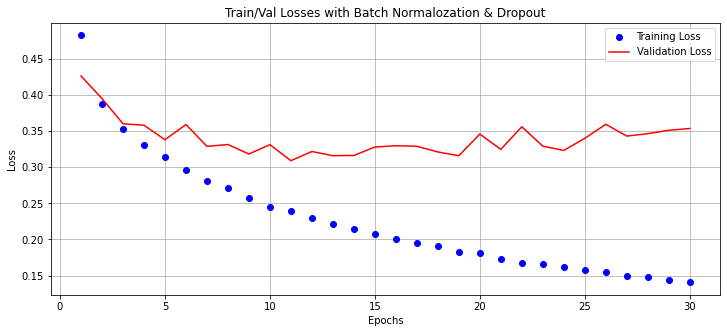

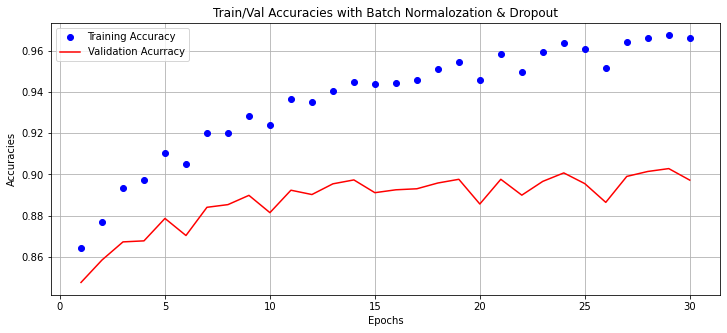

In [153]:
import matplotlib.pyplot as plt

epochs = np.arange(30) + 1
#plt.subplot(2,1,1)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_losses, 'bo', label = 'Training Loss')
plt.plot(epochs, val_losses, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Losses with Batch Normalozation & Dropout')
plt.grid('off')

#plt.subplot(2,1,2)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_accuracies, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label = 'Validation Acurracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('Train/Val Accuracies with Batch Normalozation & Dropout')
plt.grid('off')
plt.show()

# Overfitting (L1 Regularization)

In [154]:
def train_batch(x, y, model, loss_fn, optimizer):
    model.train()
    prediction, _ = model(x)
    l1_regular = 0
    for param in model.parameters():
        l1_regular = l1_regular + torch.norm(param, 1)
    batch_loss = loss_fn(prediction, y) + 0.0001*l1_regular
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [155]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [156]:
for epoch in range(30):
    print(f'epoch# {epoch+1}')
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

epoch# 1
epoch# 2
epoch# 3
epoch# 4
epoch# 5
epoch# 6
epoch# 7
epoch# 8
epoch# 9
epoch# 10
epoch# 11
epoch# 12
epoch# 13
epoch# 14
epoch# 15
epoch# 16
epoch# 17
epoch# 18
epoch# 19
epoch# 20
epoch# 21
epoch# 22
epoch# 23
epoch# 24
epoch# 25
epoch# 26
epoch# 27
epoch# 28
epoch# 29
epoch# 30


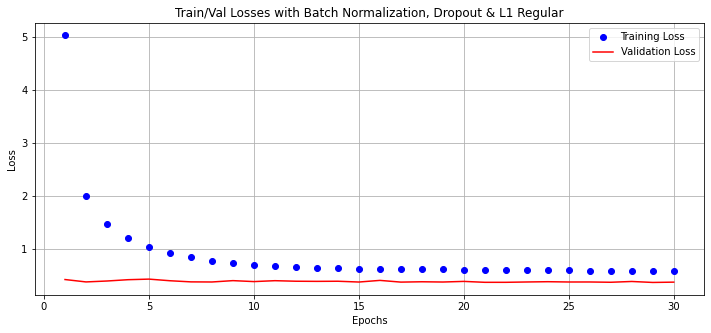

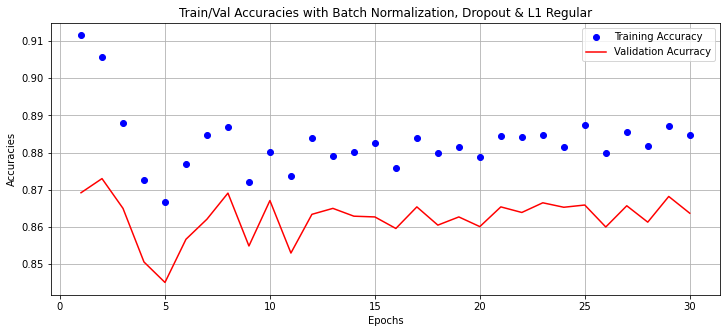

In [157]:
import matplotlib.pyplot as plt

epochs = np.arange(30) + 1
#plt.subplot(2,1,1)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_losses, 'bo', label = 'Training Loss')
plt.plot(epochs, val_losses, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Val Losses with Batch Normalization, Dropout & L1 Regular')
plt.grid('off')

#plt.subplot(2,1,2)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_accuracies, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label = 'Validation Acurracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('Train/Val Accuracies with Batch Normalization, Dropout & L1 Regular')
plt.grid('off')
plt.show()

# Overfitting (L2 Regularization)

In [158]:
def train_batch(x, y, model, loss_fn, optimizer):
    model.train()
    prediction, _ = model(x)
    l2_regular = 0
    for param in model.parameters():
        l2_regular = l2_regular + torch.norm(param, 2)
    batch_loss = loss_fn(prediction, y) + 0.01*l2_regular
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()